In [1]:
from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .master('local[*]')\
        .appName('Python Text Classification')\
        .config("spark.executor.memory", "1g")\
        .getOrCreate()

## Other Installations

In [2]:
!pip install nltk

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))

## Reindex Dataset using Pandas (Workaround)

In [6]:
import pandas as pd

pdata = pd.read_parquet('./data.parq')
pdata = pdata.reset_index(drop=True).set_index('pdf_id')
pdata.to_parquet('./reindexed_data.parq')

## Reading in the Data
I read in the exact data that is produced by the web and pdf scraper.

In [190]:
data = spark.read.option('header', 'true')\
                 .option('inferSchema', 'true')\
                 .parquet('./reindexed_data.parq')
data.createOrReplaceTempView('data')

In [191]:
data.count()

12146

## Cleaning the Data
First, I remove from the dataset any PDF documents that either did not download or scrape successfully. There are 880 of them.

In [192]:
spark.sql('''
SELECT COUNT(*)
FROM data
WHERE text is NULL
''').show(1)

+--------+
|count(1)|
+--------+
|     880|
+--------+



In addition to removing PDFs with text as `NULL`, I remove PDFs with no scraped text, which can be seen below. First I show the number of PDFs that have a small text length, being 1-10 characters long, and second, I show the actual text of those documents. We can see that those characters are just blank spaces.

In [193]:
spark.sql('''
SELECT length(trim(text)) as len, count(1) as num_pdfs
FROM data
GROUP BY len
ORDER BY 1 ASC
''').show(15)

+----+--------+
| len|num_pdfs|
+----+--------+
|null|     880|
|   1|     309|
|   2|     296|
|   3|     215|
|   4|     115|
|   5|      75|
|   6|     383|
|   7|     275|
|   8|     108|
|   9|      39|
|  10|      21|
|  27|       1|
|  46|       1|
|  52|       1|
|  73|       1|
+----+--------+
only showing top 15 rows



In [194]:
spark.sql('''
SELECT TRIM(text)
FROM data
WHERE LENGTH(text) <= 10
''').show(20)

+----------+
|trim(text)|
+----------+
|    |
|     |
|         |
|         |
|    |
||
|     |
|         |
|         |
|  |
|   |
|   |
|         |
|         |
|   |
|       |
|        |
|       |
|        |
|         |
+----------+
only showing top 20 rows



The documents that need to be dropped because of they are either null or blank spaces are 2,713, which leaves us with **9,433 documents** to train and test a model. Now, we will drop those rows.

In [195]:
data = spark.sql('''
SELECT *
FROM data
WHERE text is not NULL
''')
data.createOrReplaceTempView('data')
data = spark.sql('''
SELECT *
FROM data
WHERE length(text) > 10
''')
data.createOrReplaceTempView('data')

## Label Creation and Feature Extraction
Next, I will create the label for our data. The label will be created using the `is_fillable` column, which was a column created in the pdf scraping process. This column indicates whther the PDF document can be edited using text boxes within the PDF document. These documents will serve as our examples of forms. There are 171 of them.

In [55]:
spark.sql('''
select distinct(is_fillable), count(1)
from data
group by 1''').show(5)

+--------------------+--------+
|         is_fillable|count(1)|
+--------------------+--------+
|                null|     276|
| Not a fillable PDF.|   11340|
|Fillable Check: F...|     359|
|       Fillable PDF.|     171|
+--------------------+--------+



In [63]:
data = spark.sql('''
SELECT *, 
       CASE WHEN is_fillable == 'Fillable PDF.'
            THEN 1
            ELSE 0 END AS label
FROM data
''')
data.createOrReplaceTempView('data')

Now we will setup our tokenizer and stopwords remover, hashingTF, and TF-IDF. The rationale for using TF-IDF is due to the particular context - we are attempting to find forms which presumably contain a relatively similar set of words, and have very few words across the entire document. Hence, the context makes TF-IDF great for this.

In [196]:
from pyspark.ml.feature import (RegexTokenizer, StopWordsRemover,
                                Word2Vec, HashingTF, IDF)

regexTokenizer = RegexTokenizer(inputCol='text', outputCol='words', pattern="\\W")
stopwordsRemover = StopWordsRemover(inputCol='words', outputCol='filtered').setStopWords(stop_words)

hashingTF = HashingTF(inputCol='filtered', outputCol='rawFeatures', numFeatures=10000)
idf = IDF(inputCol='rawFeatures', outputCol='features', minDocFreq=5)

Setup and run pipeline to tokenize, remove stopwords, and create TF-IDF features.

In [173]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf])
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)

Split data in to train and test.

In [174]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

Instantiate and run training data through model.

In [176]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0, family = "binomial")
lrModel = lr.fit(trainingData)

### Model Evaluation

The coefficients for each of the 10,000 features are shown below.

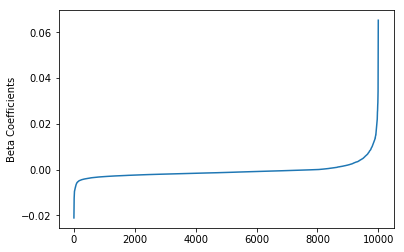

In [79]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

areaUnderROC: 0.995746727811101


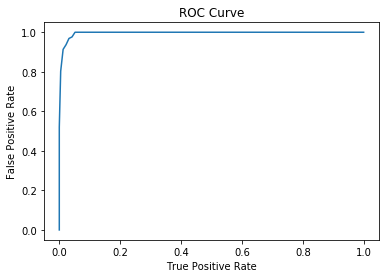

In [81]:
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

#trainingSummary.roc.show(n=10, truncate=15)
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

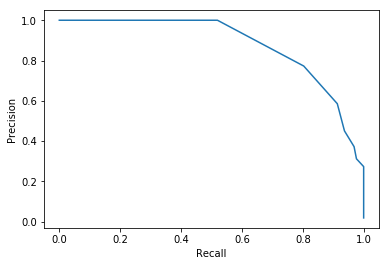

In [82]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

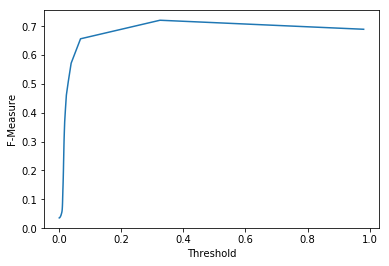

In [76]:
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

## Results
Run the test data through the model and see results. Below are the text, label, and probability attributed to each of the first 50 pdf documents in the fileset.

In [160]:
predictions = lrModel.transform(testData)

predictions.select('text',
                   'label',
                   'probability').show(n=50, truncate=40)
predictions.createOrReplaceTempView('pred')

+----------------------------------------+-----+----------------------------------------+
|                                    text|label|                             probability|
+----------------------------------------+-----+----------------------------------------+
|MEMORANDUM   To:  All Developers   Re...|    0|[0.9860441074774775,0.013955892522522...|
|Mision Christ iana’s Austin Family Ou...|    0|[0.9857423178288877,0.014257682171112...|
|Accommodations for Persons with Disab...|    1|[0.9737970419713182,0.026202958028681...|
|FREEDOM OF INFORMATION ACT   INFORMAT...|    0|[0.9787186953163186,0.02128130468368133]|
|Introduction   The  City  of  Chicago...|    0| [0.98987732923135,0.010122670768650094]|
|Introducci6n  EI  Departamento  de  A...|    0|[0.9973906456323607,0.002609354367639...|
|Accommodations for Persons with Disab...|    1|[0.9737970419713182,0.026202958028681...|
|               Pharmaceutical Represe...|    0|[0.9545097438831984,0.04549025611680157]|
|10 Things

The code below creates a new row in the data taking just the probability score of the PDF document being a form and sorts the dataset by the score in descending order. Finally, the results are put out to CSV.

In [163]:
pred = spark.sql('''
SELECT from_page, 
       pdf_url,
       num_pages,
       num_pages_scraped,
       is_fillable,
       label, 
       probability,
       prediction
FROM pred''').toPandas()
pred['prob'] = pred.probability.apply(lambda x: x[1])
pred = pred.sort_values(by='prob', ascending=False)
pred = pred[['from_page',
             'pdf_url',
             'num_pages',
             'num_pages_scraped',
             'is_fillable',
             'prediction',
             'prob',]]
pred.to_csv('./output/output.csv')

Lastly, I save the model locally. To see how the model can be run using a Docker container, see here.

In [178]:
lrModel.save('./model.model')